In [44]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier


In [55]:
test_set_feat = pd.read_csv('/content/test_set_features.csv', index_col='respondent_id')
train_set_feat = pd.read_csv('/content/training_set_features.csv', index_col='respondent_id')
train_set_lab = pd.read_csv('/content/training_set_labels.csv', index_col='respondent_id')

In [56]:
train_data = train_set_feat.join(train_set_lab)
train_data.head()


,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,xyz_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [57]:
train_data.isna().sum().sort_values(ascending=False)/len(train_data)


employment_occupation          0.504362
employment_industry            0.499120
health_insurance               0.459580
income_poverty                 0.165612
doctor_recc_xyz                0.080878
doctor_recc_seasonal           0.080878
rent_or_own                    0.076459
employment_status              0.054780
marital_status                 0.052720
education                      0.052683
chronic_med_condition          0.036358
child_under_6_months           0.030704
health_worker                  0.030104
opinion_seas_sick_from_vacc    0.020107
opinion_seas_risk              0.019246
opinion_seas_vacc_effective    0.017299
opinion_xyz_sick_from_vacc     0.014790
opinion_xyz_vacc_effective     0.014640
opinion_xyz_risk               0.014528
household_adults               0.009323
household_children             0.009323
behavioral_avoidance           0.007788
behavioral_touch_face          0.004793
xyz_knowledge                  0.004343
xyz_concern                    0.003445


In [8]:
def data_encoding(data):
    data['sex'] = data['sex'].replace({'Male': 0, 'Female': 1})
    data['marital_status'] = data['marital_status'].replace({'Not Married': 0, 'Married': 1})
    data['rent_or_own'] = data['rent_or_own'].replace({'Rent': 0, 'Own': 1})

    data['age_group'] = data['age_group'].replace({'18 - 34 Years': 0,
                                                               '35 - 44 Years': 1,
                                                               '45 - 54 Years': 2,
                                                               '55 - 64 Years': 3,
                                                               '65+ Years': 4
    })

    data['education'] = data['education'].replace({'< 12 Years': 0,
                                                               '12 Years': 1,
                                                               'Some College': 2,
                                                               'College Graduate': 3
    })

    data['income_poverty'] = data['income_poverty'].replace({'Below Poverty': 0,
                                                                         '<= $75,000, Above Poverty': 1,
                                                                         '> $75,000': 2
    })

    data['employment_status'] = data['employment_status'].replace({'Not in Labor Force': 0,
                                                                               'Unemployed': 1,
                                                                               'Employed': 2
    })

    data['census_msa'] = data['census_msa'].replace({'Non-MSA': 0,
                                                                 'MSA, Not Principle  City': 1,
                                                                 'MSA, Principle City': 2
    })



    columns_to_encode = ['race', 'hhs_geo_region', 'employment_industry', 'employment_occupation']

    encoder = OneHotEncoder(sparse=False)

    encoded_columns = encoder.fit_transform(data[columns_to_encode])

    encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))

    encoded_df.index = data.index

    data_encoded = pd.concat([data, encoded_df], axis=1)

    data_encoded.drop(columns_to_encode, axis=1, inplace=True)

    return data_encoded

In [9]:
train_data_encoded = data_encoding(train_data)

train_data_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,...,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,employment_occupation_nan
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
train_data_reencoded = pd.get_dummies(train_data_encoded, columns=train_data_encoded.columns[train_data_encoded.isna().any()], dummy_na=True)

train_data_reencoded.shape

(26707, 178)

In [11]:
train_data_reencoded2 = train_data_reencoded.drop(columns=[col for col in train_data_reencoded.columns if "_nan" in col])


In [12]:
for i in train_data_reencoded2.columns:
    print(i)

train_data_reencoded2.shape

age_group
sex
census_msa
xyz_vaccine
seasonal_vaccine
race_Black
race_Hispanic
race_Other or Multiple
race_White
hhs_geo_region_atmpeygn
hhs_geo_region_bhuqouqj
hhs_geo_region_dqpwygqj
hhs_geo_region_fpwskwrf
hhs_geo_region_kbazzjca
hhs_geo_region_lrircsnp
hhs_geo_region_lzgpxyit
hhs_geo_region_mlyzmhmf
hhs_geo_region_oxchjgsf
hhs_geo_region_qufhixun
employment_industry_arjwrbjb
employment_industry_atmlpfrs
employment_industry_cfqqtusy
employment_industry_dotnnunm
employment_industry_fcxhlnwr
employment_industry_haxffmxo
employment_industry_ldnlellj
employment_industry_mcubkhph
employment_industry_mfikgejo
employment_industry_msuufmds
employment_industry_nduyfdeo
employment_industry_phxvnwax
employment_industry_pxcmvdjn
employment_industry_qnlwzans
employment_industry_rucpziij
employment_industry_saaquncn
employment_industry_vjjrobsf
employment_industry_wlfvacwt
employment_industry_wxleyezf
employment_industry_xicduogh
employment_industry_xqicxuve
employment_occupation_bxpfxfdn
employm

(26707, 148)

In [13]:
X = train_data_reencoded.drop(columns=['xyz_vaccine','seasonal_vaccine'], axis=1)
y = train_data_reencoded[['xyz_vaccine']]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=1)

In [14]:
rf = RandomForestClassifier(random_state=1, n_jobs=-1)

param_grid = {'max_depth': [4,5,6],
              #'min_samples_leaf': [0.25,0.5,0.75],
              #'min_samples_split': [0.25,0.5,0.75],
              'max_features': [0.10,0.15,0.2,'sqrt'],
              'max_samples': [0.25,0.50],
              'class_weight': ['balanced_subsample'],
              'n_estimators': [200]
             }

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

In [18]:
%%time

# Instantiate GridSearchCV object
rf_xyz_gscv = GridSearchCV(rf, param_grid, cv=skf, scoring='roc_auc')

# Fit the data to the RF model
rf_xyz_gscv.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

CPU times: user 3min 3s, sys: 4.72 s, total: 3min 8s
Wall time: 2min 9s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             param_grid={'class_weight': ['balanced_subsample'],
                         'max_depth': [4, 5, 6],
                         'max_features': [0.1, 0.15, 0.2, 'sqrt'],
                         'max_samples': [0.25, 0.5], 'n_estimators': [200]},
             scoring='roc_auc')

In [20]:
# Best hyperparameters for RF (XYZ)
print(rf_xyz_gscv.best_estimator_)
print(rf_xyz_gscv.best_params_)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       max_features=0.15, max_samples=0.5, n_estimators=200,
                       n_jobs=-1, random_state=1)
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 0.15, 'max_samples': 0.5, 'n_estimators': 200}


In [28]:
# Predict probabilities for the TRAIN set
y_pred_proba_train_xyz = rf_xyz_gscv.predict_proba(X_train)

# Predict probabilities for the TEST set
y_pred_proba_test_xyz = rf_xyz_gscv.predict_proba(X_test)

# Predict scores for TEST set
y_preds_test_xyz = rf_xyz_gscv.predict(X_test)

In [29]:
# Create helper function to plot confusion matrix
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate).
    Returns a plot of confusion matrix for predictions on y data.
    '''
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)

    disp.plot()
    plt.show()

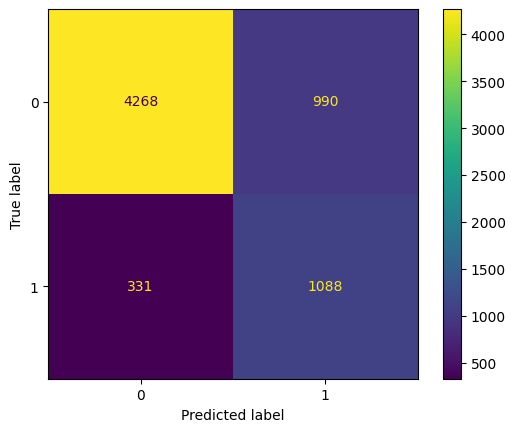

In [30]:
conf_matrix_plot(rf_xyz_gscv, X_test, y_test)


In [31]:
print(classification_report(y_test, y_preds_test_h1n1))


              precision    recall  f1-score   support

           0       0.93      0.81      0.87      5258
           1       0.52      0.77      0.62      1419

    accuracy                           0.80      6677
   macro avg       0.73      0.79      0.74      6677
weighted avg       0.84      0.80      0.81      6677



In [32]:
roc_auc_train_RF_xyz = roc_auc_score(y_train, y_pred_proba_train_xyz[:,1])
roc_auc_test_RF_xyz = roc_auc_score(y_test, y_pred_proba_test_xyz[:,1])

# Print ROC AUC scores
print(f'AUROC RF xyz Train: {roc_auc_train_RF_xyz}'
      f'\nAUROC RF xyz Test: {roc_auc_test_RF_xyz}'
)

AUROC RF xyz Train: 0.8658714256184111
AUROC RF xyz Test: 0.8640498414309307


In [46]:
# Function to draw ROC curve and print score

def draw_roc_curve(test, pred_proba):
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(test, pred_proba)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    return roc_auc_score(test, pred_proba)

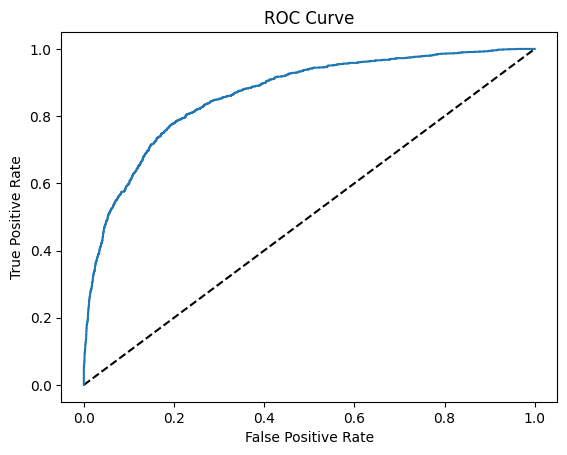

0.8640498414309307

In [47]:

#xyz Test
draw_roc_curve(y_test, y_pred_proba_test_h1n1[:,1])

In [34]:
# Split Data into Train/Test (75%/25%)
X_se = train_data_reencoded.drop(columns=['xyz_vaccine', 'seasonal_vaccine'], axis=1)
y_se = train_data_reencoded[['seasonal_vaccine']]

X_train_se, X_test_se, y_train_se, y_test_se = train_test_split(X_se, y_se,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=1)

In [35]:
# Instantiate GridSearchCV object
rf_se_gscv = GridSearchCV(rf, param_grid, cv=skf, scoring='roc_auc')

# Fit the data to the RF model
rf_se_gscv.fit(X_train_se, y_train_se)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             param_grid={'class_weight': ['balanced_subsample'],
                         'max_depth': [4, 5, 6],
                         'max_features': [0.1, 0.15, 0.2, 'sqrt'],
                         'max_samples': [0.25, 0.5], 'n_estimators': [200]},
             scoring='roc_auc')

In [36]:
print(rf_se_gscv.best_estimator_)
print(rf_se_gscv.best_params_)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       max_features=0.15, max_samples=0.5, n_estimators=200,
                       n_jobs=-1, random_state=1)
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 0.15, 'max_samples': 0.5, 'n_estimators': 200}


In [37]:
y_pred_proba_train_se = rf_se_gscv.predict_proba(X_train_se)

# Predict probabilities for the TEST set
y_pred_proba_test_se = rf_se_gscv.predict_proba(X_test_se)

# Predict scores for TEST set
y_preds_test_se = rf_se_gscv.predict(X_test_se)

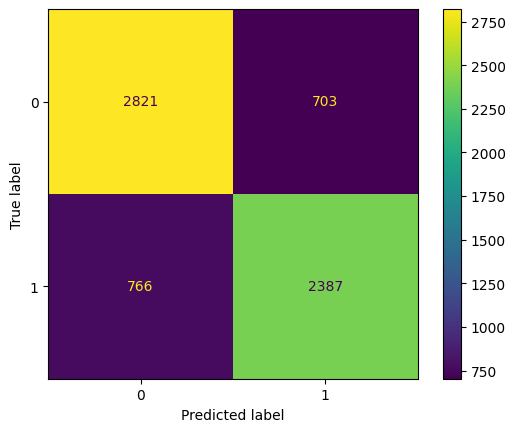

In [38]:
conf_matrix_plot(rf_se_gscv, X_test_se, y_test_se)


In [39]:
print(classification_report(y_test_se, y_preds_test_se))


              precision    recall  f1-score   support

           0       0.79      0.80      0.79      3524
           1       0.77      0.76      0.76      3153

    accuracy                           0.78      6677
   macro avg       0.78      0.78      0.78      6677
weighted avg       0.78      0.78      0.78      6677



In [45]:
# Calculate ROC AUC score for RF
roc_auc_train_RF_xyz = roc_auc_score(y_train, y_pred_proba_train_xyz[:,1])
roc_auc_test_RF_xyz = roc_auc_score(y_test, y_pred_proba_test_xyz[:,1])

# Print ROC AUC scores
print(f'AUROC RF xyz Train: {roc_auc_train_RF_xyz}'
      f'\nAUROC RF xyz Test: {roc_auc_test_RF_xyz}'
)

AUROC RF xyz Train: 0.8658714256184111
AUROC RF xyz Test: 0.8640498414309307


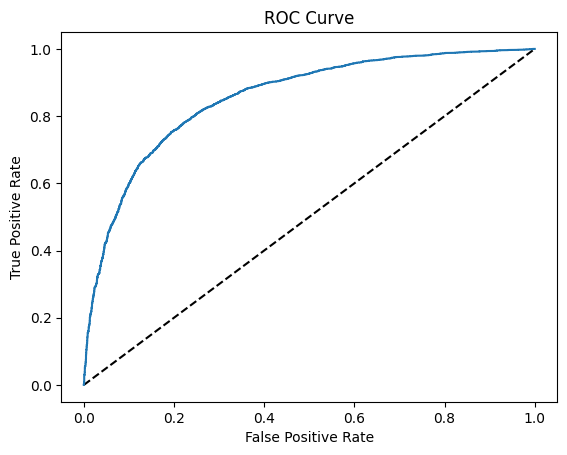

0.8545566570295194

In [48]:
draw_roc_curve(y_test_se, y_pred_proba_test_se[:,1])


In [49]:
roc_auc_train_RF_se = roc_auc_score(y_train_se, y_pred_proba_train_se[:,1])
roc_auc_test_RF_se = roc_auc_score(y_test_se, y_pred_proba_test_se[:,1])

# Print ROC AUC scores
print(f'AUROC RF Seasonal Train: {roc_auc_train_RF_se}'
      f'\nAUROC RF Seasonal Test: {roc_auc_test_RF_se}'
)

AUROC RF Seasonal Train: 0.8513534525487501
AUROC RF Seasonal Test: 0.8545566570295194


In [50]:
!pip install optuna

import optuna
import optuna.visualization as vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00


In [51]:
# Step 1: Define the objective function for Optuna to minimize
def objective_h1n1(trial):
    # Define the hyperparameters to tune
    params = {
        'class_weight': 'balanced_subsample',
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'max_samples': trial.suggest_uniform('max_samples', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    }

    # Train an RF model with the current hyperparameters
    model = RandomForestClassifier(**params, random_state=1)
    model.fit(X_train, y_train)

    # Evaluate the model on the validation set and return the score
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

In [52]:
%%time
# Step 2: Create an Optuna study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective_h1n1, n_trials=200)

[I 2024-06-17 17:42:52,743] A new study created in memory with name: no-name-393cf4f7-9ecb-4194-a827-3f5de87aaa34
<ipython-input-51-2ac8636cbcaa>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_samples': trial.suggest_uniform('max_samples', 0.01, 1.0),
<ipython-input-51-2ac8636cbcaa>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
[I 2024-06-17 17:43:00,460] Trial 0 finished with value: 0.8618787144311927 and parameters: {'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 27, 'max_features': 'sqrt', 'max_samples': 0.697677824254226, 'n_estimators': 184}. Best is trial 0 with value: 0.8618787144311927.
<ipython-input-51-2ac8636cbcaa>:10: FutureWarning: suggest_uniform has been deprecated in 

CPU times: user 11min 14s, sys: 1.91 s, total: 11min 16s
Wall time: 13min 9s


In [54]:
study_xyz_df = study.trials_dataframe()

study_xyz_df.sort_values(by='value', ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_max_samples,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
74,74,0.870001,2024-06-17 17:47:55.193235,2024-06-17 17:48:05.212466,0 days 00:00:10.019231,10,sqrt,0.695244,4,22,154,COMPLETE
102,102,0.869461,2024-06-17 17:50:00.602413,2024-06-17 17:50:04.865203,0 days 00:00:04.262790,10,sqrt,0.668451,6,26,150,COMPLETE
173,173,0.869408,2024-06-17 17:54:35.636208,2024-06-17 17:54:38.759106,0 days 00:00:03.122898,10,sqrt,0.724730,5,27,146,COMPLETE
111,111,0.869332,2024-06-17 17:50:38.973655,2024-06-17 17:50:42.098910,0 days 00:00:03.125255,10,auto,0.516876,3,13,160,COMPLETE
122,122,0.869222,2024-06-17 17:51:28.769573,2024-06-17 17:51:36.229238,0 days 00:00:07.459665,10,auto,0.656627,4,19,160,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
40,40,0.848602,2024-06-17 17:45:27.469129,2024-06-17 17:45:29.692731,0 days 00:00:02.223602,4,log2,0.909728,56,54,184,COMPLETE
3,3,0.846620,2024-06-17 17:43:05.780672,2024-06-17 17:43:07.004347,0 days 00:00:01.223675,4,log2,0.680344,26,70,112,COMPLETE
27,27,0.844419,2024-06-17 17:44:44.088604,2024-06-17 17:44:46.956282,0 days 00:00:02.867678,2,sqrt,0.927806,47,44,177,COMPLETE
69,69,0.843301,2024-06-17 17:47:27.841075,2024-06-17 17:47:29.564958,0 days 00:00:01.723883,2,sqrt,0.731121,15,27,83,COMPLETE


In [58]:
print(f'Best score: {study.best_value:.5f}')
print('Best parameters:')
for key, value in study.best_params.items():
    print(f'    {key}: {value}')

Best score: 0.87000
Best parameters:
    max_depth: 10
    min_samples_leaf: 4
    min_samples_split: 22
    max_features: sqrt
    max_samples: 0.6952435338067464
    n_estimators: 154


In [59]:
# Plot parameter importance
vis.plot_param_importances(study)

In [60]:
# Step 1: Define the objective function for Optuna to minimize
def objective_se(trial):
    # Define the hyperparameters to tune
    params = {
        'class_weight': 'balanced_subsample',
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'max_samples': trial.suggest_uniform('max_samples', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    }

    # Train an RF model with the current hyperparameters
    model = RandomForestClassifier(**params, random_state=1, n_jobs=-1)
    model.fit(X_train_se, y_train_se)

    # Evaluate the model on the validation set and return the score
    y_pred_proba = model.predict_proba(X_test_se)[:, 1]
    return roc_auc_score(y_test_se, y_pred_proba)

In [61]:
%%time
# Step 2: Create an Optuna study object and optimize the objective function
study_se = optuna.create_study(direction='maximize')
study_se.optimize(objective_se, n_trials=200)

[I 2024-06-17 17:56:43,939] A new study created in memory with name: no-name-6ede8fc2-0959-42fd-852b-90eae0025cf2
<ipython-input-60-78f47873341d>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-60-78f47873341d>:16: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2024-06-17 17:56:45,219] Trial 0 finished with value: 0.8373927160879159 and parameters: {'max_depth': 2, 'min_samples_leaf': 37, 'min_samples_split': 71, 'max_features': 'log2', 'max_samples': 0.6168607703647808, 'n_estimators': 156}. Best is trial 0 with value: 0.8373927160879159.
<ipython-input-60-78f47873341d>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/relea

CPU times: user 12min 22s, sys: 10.2 s, total: 12min 32s
Wall time: 8min 29s


In [62]:
# Convert study into DataFrame

study_se_df = study_se.trials_dataframe()

study_se_df.sort_values(by='value', ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_max_samples,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
167,167,0.862917,2024-06-17 18:04:05.264946,2024-06-17 18:04:07.951603,0 days 00:00:02.686657,10,sqrt,0.487585,1,3,115,COMPLETE
41,41,0.862741,2024-06-17 17:58:14.617739,2024-06-17 17:58:17.948821,0 days 00:00:03.331082,10,auto,0.646856,1,47,187,COMPLETE
162,162,0.862741,2024-06-17 18:03:56.639787,2024-06-17 18:03:58.377235,0 days 00:00:01.737448,10,sqrt,0.475653,1,9,111,COMPLETE
184,184,0.862611,2024-06-17 18:04:40.351949,2024-06-17 18:04:42.244435,0 days 00:00:01.892486,10,sqrt,0.479435,1,12,117,COMPLETE
151,151,0.862577,2024-06-17 18:03:32.226127,2024-06-17 18:03:36.479407,0 days 00:00:04.253280,10,sqrt,0.560715,1,13,109,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
5,5,0.838079,2024-06-17 17:56:53.665070,2024-06-17 17:56:54.349405,0 days 00:00:00.684335,5,sqrt,0.048460,63,3,117,COMPLETE
0,0,0.837393,2024-06-17 17:56:43.940933,2024-06-17 17:56:45.218951,0 days 00:00:01.278018,2,log2,0.616861,37,71,156,COMPLETE
30,30,0.836480,2024-06-17 17:57:41.764888,2024-06-17 17:57:42.998610,0 days 00:00:01.233722,2,log2,0.332613,30,39,162,COMPLETE
60,60,0.834147,2024-06-17 17:59:16.574183,2024-06-17 17:59:17.679044,0 days 00:00:01.104861,9,log2,0.013460,17,8,189,COMPLETE


In [63]:
# Step 3: Print the best hyperparameters and score found by Optuna
print(f'Best score: {study_se.best_value:.5f}')
print('Best parameters:')
for key, value in study_se.best_params.items():
    print(f'    {key}: {value}')

Best score: 0.86292
Best parameters:
    max_depth: 10
    min_samples_leaf: 1
    min_samples_split: 3
    max_features: sqrt
    max_samples: 0.487585074991475
    n_estimators: 115


In [64]:
# Plot parameter importance
vis.plot_param_importances(study_se)

<ipython-input-67-dbfd58d6ea54>:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



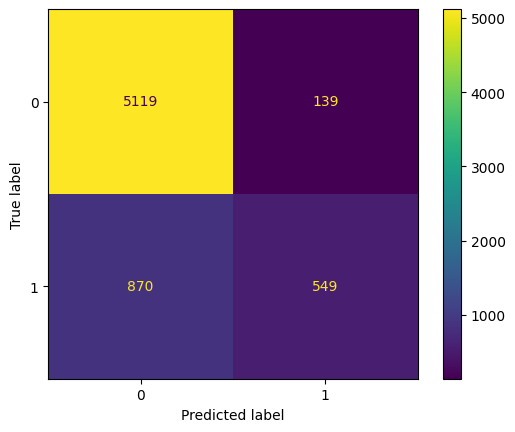

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      5258
           1       0.80      0.39      0.52      1419

    accuracy                           0.85      6677
   macro avg       0.83      0.68      0.72      6677
weighted avg       0.84      0.85      0.83      6677



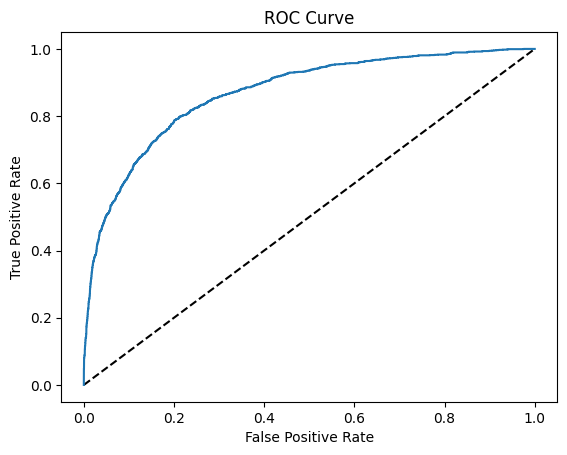

AUROC XGB H1N1 Train: 0.8917944284807098
AUROC XGB H1N1 Test: 0.8682472106667354


In [67]:
# XYZ w/ Optuna
rf_xyz_opt = RandomForestClassifier(**study.best_params)

# Fit the model on the entire training set
rf_xyz_opt.fit(X_train, y_train)

# Predict probabilities for the TRAIN set
y_pred_proba_train_xyz_opt = rf_xyz_opt.predict_proba(X_train)

# Predict probabilities for the TEST set
y_pred_proba_test_xyz_opt = rf_xyz_opt.predict_proba(X_test)

# Predict scores for TEST set
y_preds_test_xyz_opt = rf_xyz_opt.predict(X_test)
# Display Confusion Matrix
conf_matrix_plot(rf_xyz_opt, X_test, y_test)

# Classification Report (XYZ)
print(classification_report(y_test, y_preds_test_xyz_opt))

# Seasonal Test
draw_roc_curve(y_test, y_pred_proba_test_xyz_opt[:,1])

# Calculate ROC AUC score for RF
roc_auc_train_rf_xyz_opt = roc_auc_score(y_train, y_pred_proba_train_xyz_opt[:,1])
roc_auc_test_rf_xyz_opt = roc_auc_score(y_test, y_pred_proba_test_xyz_opt[:,1])

# Print ROC AUC scores
print(f'AUROC XGB H1N1 Train: {roc_auc_train_rf_xyz_opt}'
      f'\nAUROC XGB H1N1 Test: {roc_auc_test_rf_xyz_opt}'
)

<ipython-input-68-2b4e194bdcfd>:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



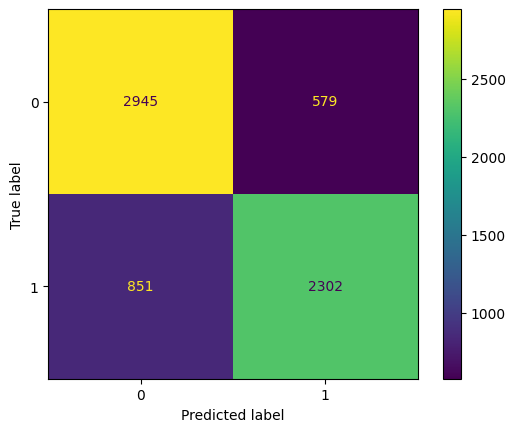

              precision    recall  f1-score   support

           0       0.78      0.84      0.80      3524
           1       0.80      0.73      0.76      3153

    accuracy                           0.79      6677
   macro avg       0.79      0.78      0.78      6677
weighted avg       0.79      0.79      0.78      6677



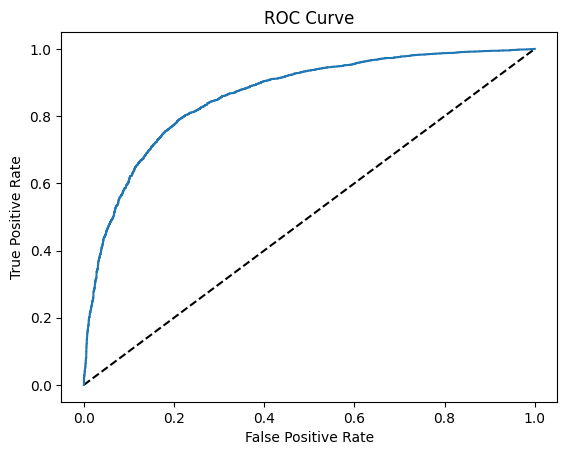

AUROC RF Seasonal Train: 0.8912378440826962
AUROC RF Seasonal Test: 0.8614774391036337


In [68]:
# Seasonal w/ Optuna
rf_se_opt = RandomForestClassifier(**study_se.best_params)

# Fit the model on the entire training set
rf_se_opt.fit(X_train_se, y_train_se)

# Predict probabilities for the TRAIN set
y_pred_proba_train_se_opt = rf_se_opt.predict_proba(X_train_se)

# Predict probabilities for the TEST set
y_pred_proba_test_se_opt = rf_se_opt.predict_proba(X_test_se)

# Predict scores for TEST set
y_preds_test_se_opt = rf_se_opt.predict(X_test_se)
# Display Confusion Matrix
conf_matrix_plot(rf_se_opt, X_test_se, y_test_se)

# Classification Report (Seasonal)
print(classification_report(y_test_se, y_preds_test_se_opt))

# Seasonal Test
draw_roc_curve(y_test_se, y_pred_proba_test_se_opt[:,1])

# Calculate ROC AUC score for RF
roc_auc_train_rf_se_opt = roc_auc_score(y_train_se, y_pred_proba_train_se_opt[:,1])
roc_auc_test_rf_se_opt = roc_auc_score(y_test_se, y_pred_proba_test_se_opt[:,1])

# Print ROC AUC scores
print(f'AUROC RF Seasonal Train: {roc_auc_train_rf_se_opt}'
      f'\nAUROC RF Seasonal Test: {roc_auc_test_rf_se_opt}'
)

In [69]:
# Join test_set_feat and train_set_lab by 'respondent_id' column
test_data = test_set_feat

test_data.head()

,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


In [70]:
# Use function to transform test set data
test_data_encoded = data_encoding(test_data)
# Additional Step for Random Forest
# One Hot Encode columns with missing values
test_data_reencoded = pd.get_dummies(test_data_encoded, columns=test_data_encoded.columns[test_data_encoded.isna().any()], dummy_na=True)

test_data_reencoded.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



(26708, 176)

In [71]:

# Fit on Entire Training Dataset (H1N1)
rf_xyz_opt.fit(X, y)

# Fit on Entire Training Dataset (Seasonal)
rf_se_opt.fit(X_se, y_se)

<ipython-input-71-5e883e023388>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

<ipython-input-71-5e883e023388>:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(max_depth=10, max_samples=0.487585074991475,
                       min_samples_split=3, n_estimators=115)

In [77]:
# Predict probabilities for the unseen data (H1N1)
y_test_data_pred_proba_rf_xyz = rf_xyz_opt.predict_proba(test_data_reencoded)
print(y_test_data_pred_proba_rf_xyz[:,1])

# Predict probabilities for the unseen data (Seasonal)
y_test_data_pred_proba_rf_se = rf_se_opt.predict_proba(test_data_reencoded)
print(y_test_data_pred_proba_rf_se[:,1])

[0.18128973 0.04503705 0.21132708 ... 0.14423506 0.06346265 0.4685839 ]
[0.27408255 0.08117092 0.68440837 ... 0.25736464 0.33457483 0.56555836]


In [82]:
submission = pd.DataFrame()

submission['xyz_vaccine'] = y_test_data_pred_proba_rf_h1n1[:,1]
submission['seasonal_vaccine'] = y_test_data_pred_proba_rf_se[:,1]

submission.to_csv('/my_submission_file.csv', index=False)

In [83]:
submission


,xyz_vaccine,seasonal_vaccine
0,0.181290,0.274083
1,0.045037,0.081171
2,0.211327,0.684408
3,0.532933,0.810161
4,0.355490,0.512663
...,...,...
26703,0.264424,0.499504
26704,0.166864,0.399853
26705,0.144235,0.257365
26706,0.063463,0.334575
